# Exercise 4

## Import packages

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [12]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to GPU if use_cuda is True
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)        
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [13]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [14]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)

        # TODO: run network layers
        x = self.fc1(x)
        x = F.sigmoid(x)

        x = self.fc2(x)
        x = F.sigmoid(x)

        x = self.fc3(x)
        x = F.sigmoid(x)

        x = self.fc4(x)
        x = F.sigmoid(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [15]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)

        # TODO: run network layers
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [16]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity and batch normalization to the first and third layers
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

        self.bn1 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(60)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)

        # TODO: run network layers
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [17]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [18]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    batch normalization to first convolutional and first fully connected layer
    use max pooling instead of stride to reduce the dimensions to 64x12x12
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.bn_fc1 = nn.BatchNorm1d(128)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [19]:
class ConvNet3(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers and batch normalization to first convolutional and first fully connected layer
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.pooling = nn.MaxPool2d(2)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.pooling(x)
        x = F.relu(x)

        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.377647
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.333517
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.385033
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.385702
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.280001
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.405735
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.388482
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.441139
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.262756
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.380276

Test set: Average loss: 0.2839, Accuracy: 8847/10000 (88.47%)



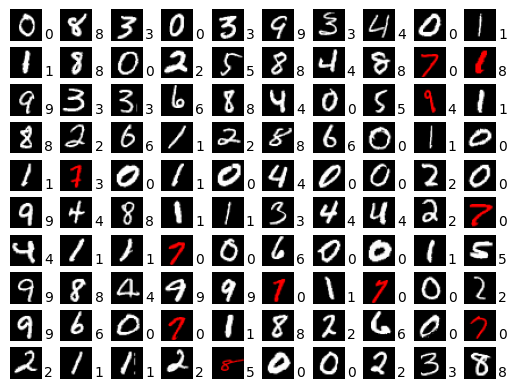

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.198602
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.492267
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.271192
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.258552
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.201418
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.327331
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.304967
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.292150
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.082070
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.199754

Test set: Average loss: 0.2654, Accuracy: 8890/10000 (88.90%)



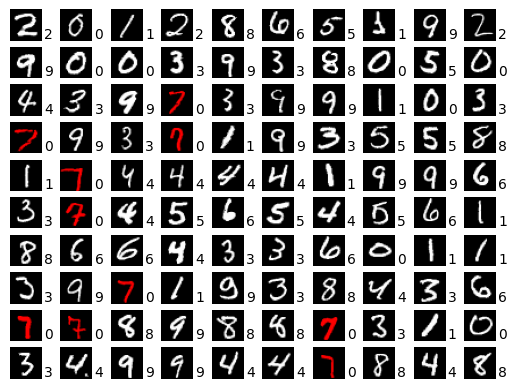

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.184414
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.315555
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.378598
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.360286
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.301713
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.397864
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.252686
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.289949
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.309253
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.184305

Test set: Average loss: 0.2619, Accuracy: 8909/10000 (89.09%)



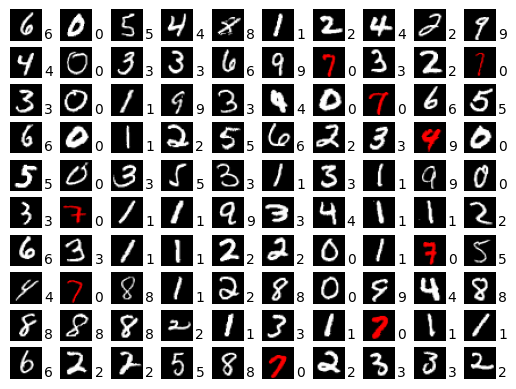

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.293845
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.238448
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.217925
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.181370
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.359783
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.185649
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.011171
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.004588
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.006838
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.032487

Test set: Average loss: 0.0283, Accuracy: 9914/10000 (99.14%)



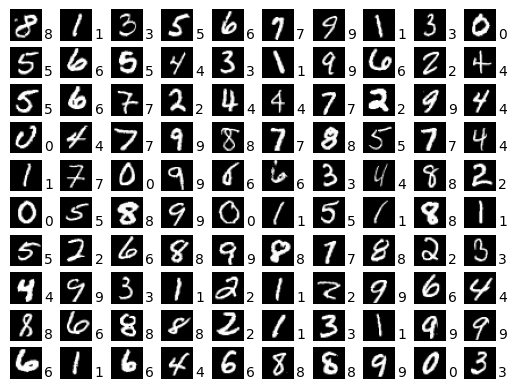

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.046578
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.002996
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.007712
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.036321
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000497
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001276
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.002980
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.001691
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000867
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.001115

Test set: Average loss: 0.0265, Accuracy: 9924/10000 (99.24%)



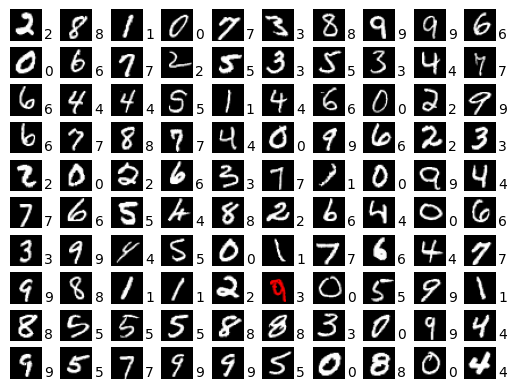

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.002264
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.002732
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.005418
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000682
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.002990
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.001027
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.001183
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.001474
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.001048
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.004458

Test set: Average loss: 0.0253, Accuracy: 9923/10000 (99.23%)



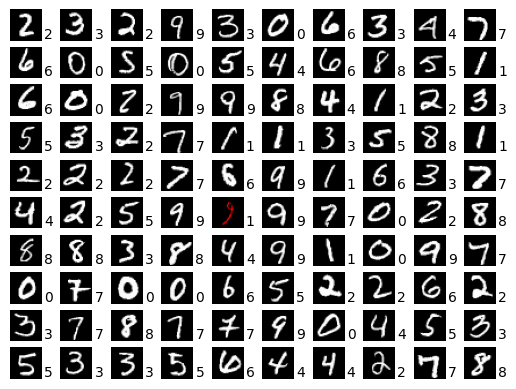

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.002285
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000544
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.002838
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000486
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000711
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.001405
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000290
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.003637
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.001190
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000736

Test set: Average loss: 0.0263, Accuracy: 9925/10000 (99.25%)



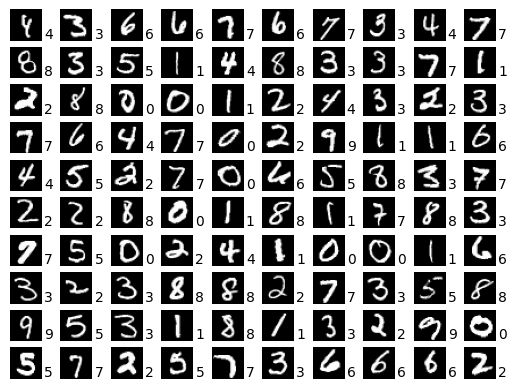

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000241
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000660
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000261
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.001285
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.001159
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000265
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000456
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.001460
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.119246
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.001017

Test set: Average loss: 0.0254, Accuracy: 9925/10000 (99.25%)



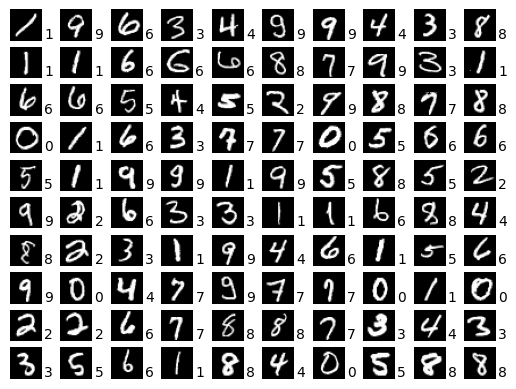

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.008539
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.001629
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000847
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000446
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000378
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000853
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000182
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.001286
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000643
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000686

Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)



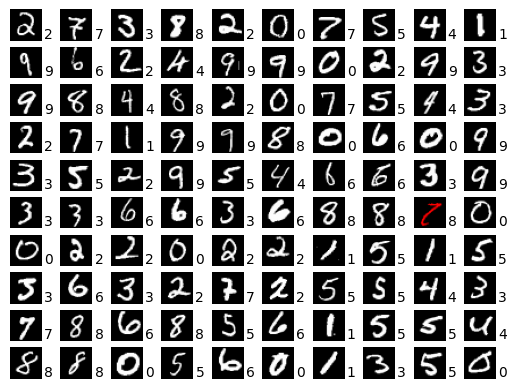

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000530
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000678
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000219
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000513
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.001636
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000308
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000159
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.003933
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000274
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.001400

Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)



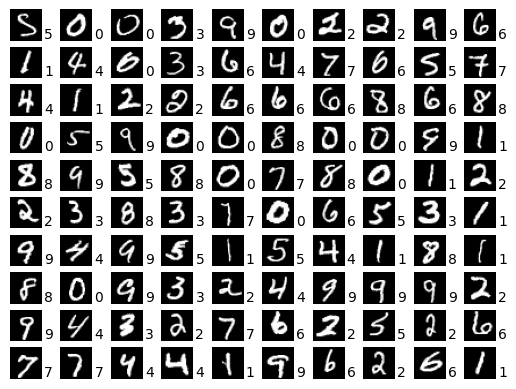

In [20]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")